# Generalized MLM distribution simulation

In [1]:
library(evd)
library(maxstablePCA)
library(ggplot2)
library(dplyr)
library(GGally)
library(graphicalExtremes)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



### setup parameters and simulate data

In [2]:
set.seed(74106)
s <- 500
n <- 100000

In [3]:
Z <- rmvevd(n, dep = .8, model = "log", d = 3, mar = c(1,1,1))

In [4]:
A <- matrix(NA, 6, 3)
A[1:3, ] <- matrix(c(
    0.9, 0.1, 0.3, 0,0.9,0, 0.1, 0, 0.7
), 3, 3)
A[4:6, ] <- matrix(
    c(0.3, 0.55, 0.15, 
     0.65, 0, 0.35, 
     0.3, 0.2, 0.5), 
    byrow = T, 3, 3)

In [5]:
A

0.90,0.00,0.10
0.10,0.90,0.00
0.30,0.00,0.70
0.30,0.55,0.15
0.65,0.00,0.35
0.30,0.20,0.50


In [6]:
X <- t(maxmatmul(A, t(Z)))
Xtrafo <- transform_unitpareto(X)

# max-stable PCA for X

In [7]:
summary(rowSums(Xtrafo))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     6.0      9.1     13.7     72.5     26.3 500000.0 

In [8]:
length(which(apply(Xtrafo, 1, max) > s))

[1] 445

In [9]:
maxPCA1 <- max_stable_prcomp(Xtrafo, p = 1, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCA2 <- max_stable_prcomp(Xtrafo, p = 2, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCA3 <- max_stable_prcomp(Xtrafo, p = 3, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCA4 <- max_stable_prcomp(Xtrafo, p = 4, s = s, n_initial_guesses = 15000, norm = "linfty")

### inspect relevant output 

In [10]:
maxPCA3

$p
[1] 3

$d
[1] 6

$decoder_matrix
             [,1]         [,2]      [,3]
[1,] 0.0006388014 0.0002403652 1.2514313
[2,] 0.0248026137 1.4753723944 0.0904969
[3,] 0.0063686655 0.0001515950 0.4619628
[4,] 0.0209986019 1.1719794086 0.2770782
[5,] 0.0011188704 0.0002227731 1.0308314
[6,] 1.2178607613 0.2240295274 0.1593189

$encoder_matrix
          [,1]         [,2]      [,3]         [,4]      [,5]         [,6]
[1,] 0.2080013 6.272138e-02 0.5268083 6.731328e-02 0.1878322 0.8211284622
[2,] 0.2130230 2.465796e-01 0.1330210 8.532600e-01 0.1223144 0.0748146903
[3,] 0.7990851 2.894971e-05 0.4129583 1.323452e-09 0.3899704 0.0003682796

$reconstr_matrix
          [,1]         [,2]      [,3]         [,4]      [,5]         [,6]
[1,] 1.0000002 5.926915e-05 0.5167890 0.0002050940 0.4880211 0.0005245380
[2,] 0.3142882 3.637967e-01 0.1962555 1.2588762297 0.1804592 0.1103795288
[3,] 0.3691476 3.994515e-04 0.1907714 0.0004286958 0.1801518 0.0052294925
[4,] 0.2496585 2.889862e-01 0.1558979 1.0000031346

In [11]:
maxPCA3$optim_conv_status

[1] 4

### report rounded estimated matrices

In [12]:
round(maxPCA3$decoder_matrix, 2)

0.00,0.00,1.25
0.02,1.48,0.09
0.01,0.00,0.46
0.02,1.17,0.28
0.00,0.00,1.03
1.22,0.22,0.16


In [13]:
round(maxPCA3$encoder_matrix, 2)

0.21,0.06,0.53,0.07,0.19,0.82
0.21,0.25,0.13,0.85,0.12,0.07
0.80,0.00,0.41,0.00,0.39,0.00


In [14]:
round(maxPCA3$reconstr_matrix, 2)

1.00,0.00,0.52,0.00,0.49,0.00
0.31,0.36,0.20,1.26,0.18,0.11
0.37,0.00,0.19,0.00,0.18,0.01
0.25,0.29,0.16,1.00,0.14,0.09
0.82,0.00,0.43,0.00,0.40,0.00
0.25,0.08,0.64,0.19,0.23,1.00


# Elbow plot for reconstruction error 

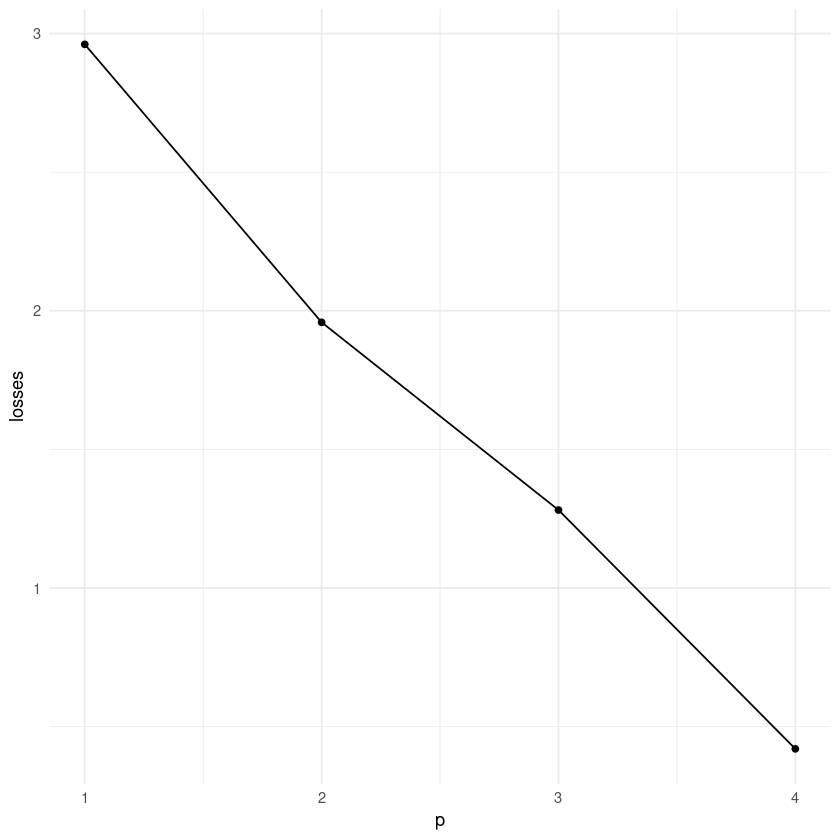

In [15]:
plotdat <- data.frame(p = 1:4, losses = c(
    maxPCA1$loss_fctn_value,
    maxPCA2$loss_fctn_value,
    maxPCA3$loss_fctn_value,
    maxPCA4$loss_fctn_value   
))

pe <- ggplot(aes(x = p, y = losses), data = plotdat) + geom_line() + geom_point() + theme_minimal()
pe

In [16]:
ggsave("genmlm_elbow.pdf", pe)

Saving 6.67 x 6.67 in image


# pairplot to visually inspect reconstruction

In [17]:
datX <- data.frame(X)
rec <- t(maxmatmul(maxPCA3$reconstr_matrix, t(as.matrix(datX))))
datX$is_rec = "original"
datrec <- data.frame(rec)
datrec$is_rec = "reconstruction"
names(datrec) <- names(datX)
plot_datX <- full_join(datX, datrec)

Joining with `by = join_by(X1, X2, X3, X4, X5, X6, is_rec)`


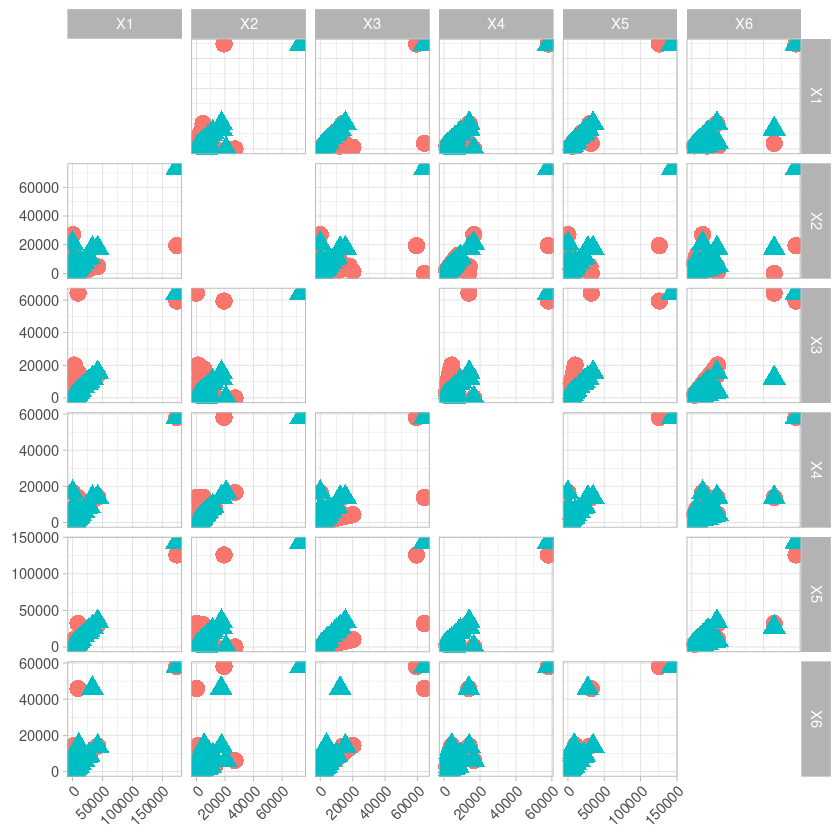

In [18]:
p <- ggpairs(
    plot_datX, 
    aes(color = is_rec, shape = is_rec, size = 2),
    columns = 1:6,
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

p

# Comparison to other methodologies 

In [19]:
Xsphere1 <- t(apply(Xtrafo, 1, function(z) z / max(z)))
Xsphere1 <- Xsphere1[which(apply(Xtrafo, 1, max) > s), ]

In [20]:
specdecomp1 <- eigen(s / n * t(Xsphere1) %*% Xsphere1)
specdecomp1

eigen() decomposition
$values
[1] 3.001739000 0.964455989 0.468578109 0.017399635 0.005016439 0.004077910

$vectors
           [,1]        [,2]         [,3]       [,4]        [,5]       [,6]
[1,] -0.4477489  0.28515331 -0.636785311  0.2302264 -0.49341797 -0.1274656
[2,] -0.3411156 -0.74428866 -0.007649961  0.5097657  0.06073497  0.2570334
[3,] -0.4238215  0.28685916  0.621187050  0.3719062  0.04122577 -0.4606518
[4,] -0.3755067 -0.42963551 -0.085405210 -0.6179901  0.05164191 -0.5315405
[5,] -0.4426927  0.30289770 -0.228332315 -0.0901635  0.75629065  0.2829054
[6,] -0.4081106  0.07810318  0.386190238 -0.3984712 -0.42012851  0.5855899


In [21]:
rec1 <- X %*% specdecomp1$vectors[1:6, 1:3] %*% t(specdecomp1$vectors[1:6, 1:3])

plotdat_DS1 <- data.frame(X)
tmp <- data.frame(rec1)
plotdat_DS1 <- full_join(plotdat_DS1, tmp)
plotdat_DS1$is_rec <- c(rep(F, 10000), rep(T, 10000))

Joining with `by = join_by(X1, X2, X3, X4, X5, X6)`


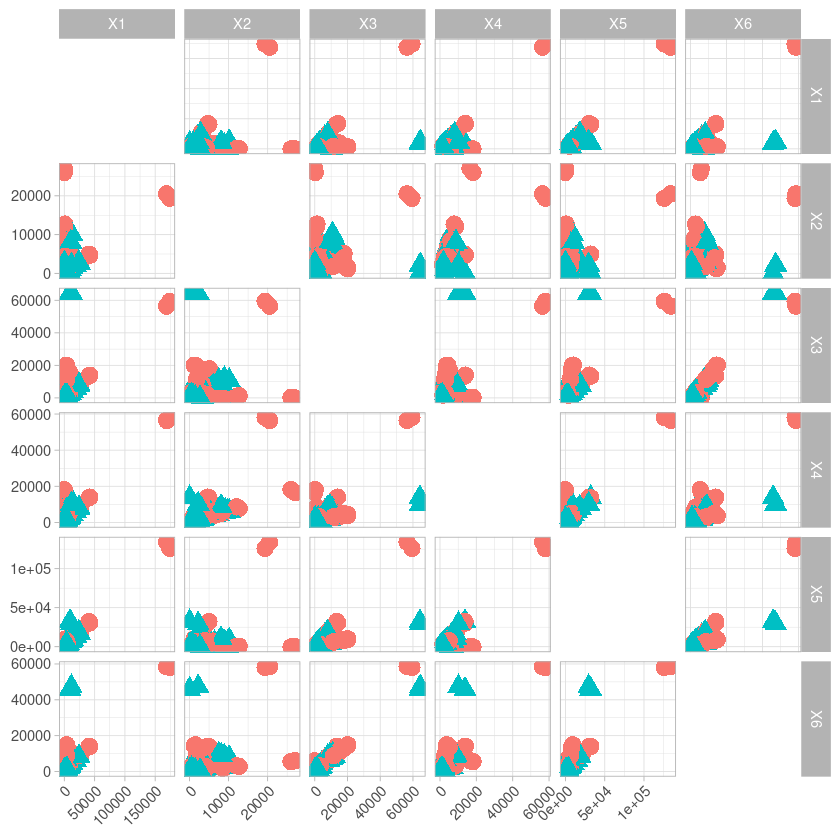

In [22]:
p <- ggpairs(
    plotdat_DS1, 
    aes(color = is_rec, shape = is_rec, size = 2),
    columns = 1:6,
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

p

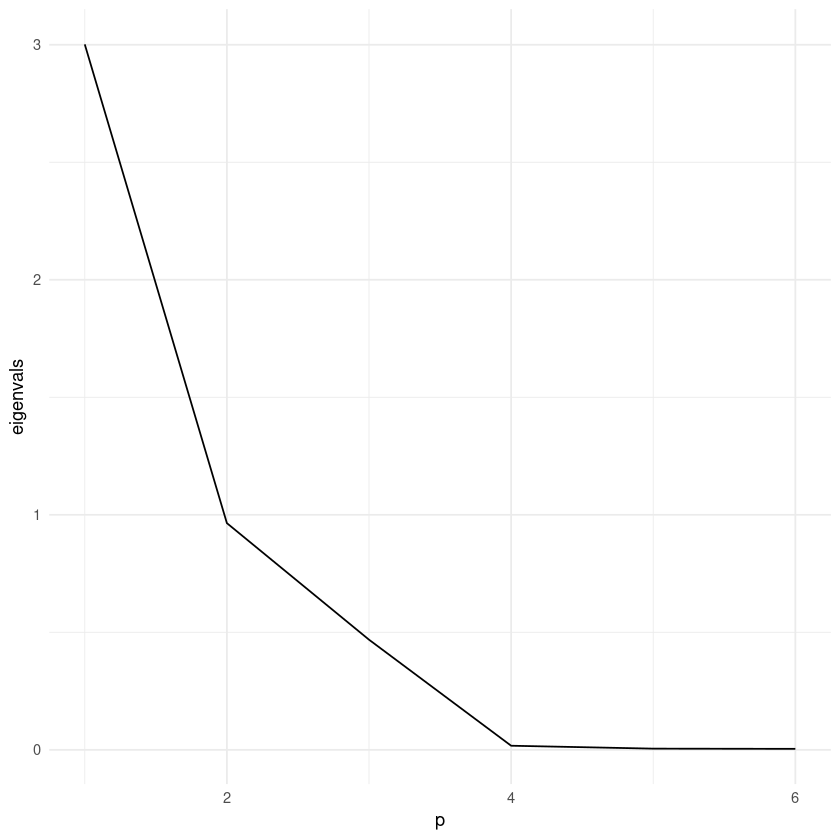

In [23]:
screeplotdat <- data.frame(p = 1:6, eigenvals = specdecomp1$values)

ggplot(aes(x = p, y = eigenvals), data = screeplotdat) + 
geom_line() + 
theme_minimal()

# Spherical K-means

In [24]:
library(skmeans)

In [25]:
kmeanserrs = data.frame(k = 1:6, errs = NA)
kmeansclusterings = list()
for(k in 2:6) {
    tmp <- skmeans::skmeans(X[which(rowSums(X) > 250), ], k = k)
    kmeansclusterings[[k]] <- tmp
    kmeanserrs[k,2] <- tmp$value
}

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


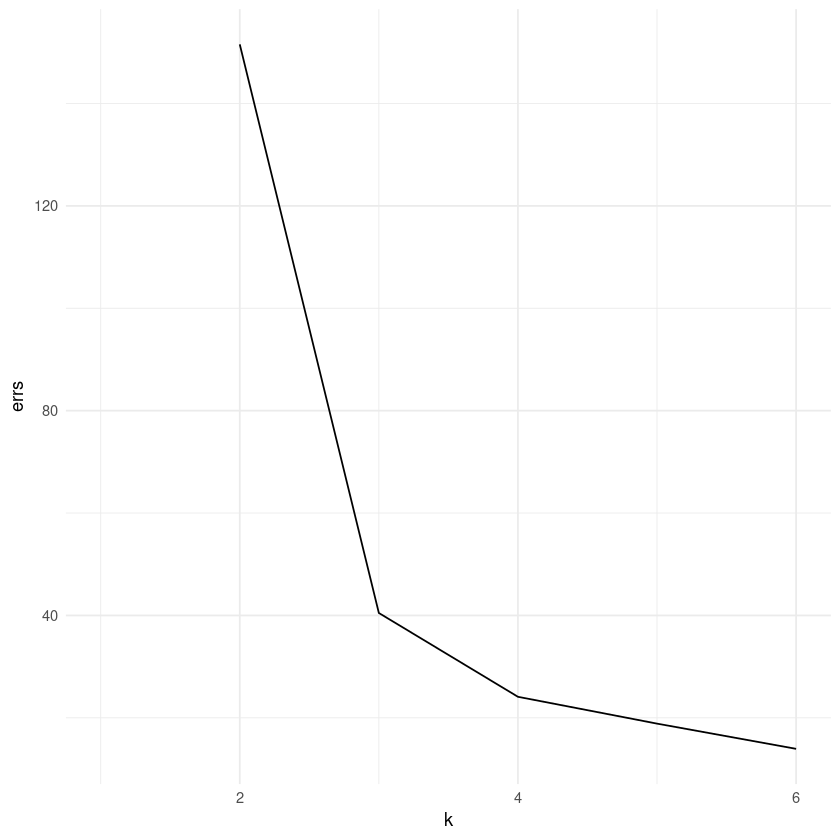

In [26]:
ggplot(aes(x = k, y = errs), data = kmeanserrs) + 
geom_line() +
theme_minimal()

### Cooley PCA

In [27]:
# Tail pairwise dependence matrix code by Yiang 

decls <- function(x, th, k) {
    ## Ordinary decluster.
    id.big <- which(x > th)
    id.dif <- diff(id.big)
    tick <- which(id.dif >= k)
    start <- id.big[c(1, tick + 1)]              # Where a new cluster begins
    end <- c(id.big[tick], last(id.big, 1))
    n <- length(start)
    id.res <- rep(0, n)
    for ( i in 1 : n) {
        temp <- x[start[i] : end[i]]
        id.res[i] <- which(temp == max(temp, na.rm = TRUE))[1] + start[i] - 1
    }
    id.res
}

rw.Sigma <- function(X, u = 0.98, decluster = F) {
    ## Compute TPDM
    P <- ncol(X)                      # Number of stations
    M <- nrow(X)                      # Number of obs
    Sigma <- matrix(0, P, P)
    for ( i in 1 : P) {
        if (i %% 5 == 0) print(i)
        for ( j in 1 : P) {
            r <- sqrt(X[, i] ^ 2 + X[, j] ^ 2)
            w1 <- X[, i] / r
            w2 <- X[, j] / r
            th <- quantile(r, u, na.rm = TRUE)
            if(decluster) {
                id <- decls(r, th, 5)
            } else {
                id <- which(r > th)
            } 
            Sigma[i, j] <- sum(w1[id] * w2[id], na.rm = TRUE) / (length(id)) * 2
        }
    }
    Sigma
}

ecdf_shifted <- function(z) length(z) / (length(z) + 1) * ecdf(z)(z) + 1 / (length(z) + 1)

In [28]:
# Transform data to approximately 2-Fréchet margins 
Xtrafo_2frech <- apply(Xtrafo, 2, function(z) sqrt(-log(ecdf_shifted(z))))

In [29]:
tpdm <- rw.Sigma(Xtrafo_2frech)
# tpdm <- nearPD(tpdm)$mat

[1] 5


In [30]:
specdecomp_cy <- eigen(tpdm)

In [31]:
specdecomp_cy

eigen() decomposition
$values
[1] 5.700869486 0.188882969 0.082634985 0.015411284 0.007351770 0.004849506

$vectors
           [,1]       [,2]        [,3]       [,4]        [,5]       [,6]
[1,] -0.4066608 -0.2916656  0.68573005 -0.2363810  0.37942614 -0.2819438
[2,] -0.3964198  0.7277114  0.03414941 -0.4844911 -0.02302687  0.2772352
[3,] -0.4085874 -0.3319048 -0.52987849 -0.4229809 -0.30530594 -0.4123103
[4,] -0.4115203  0.3737053  0.06620205  0.6431063 -0.22368195 -0.4722217
[5,] -0.4122247 -0.3537556  0.20180773  0.1931060 -0.50504389  0.6097887
[6,] -0.4138316 -0.1020189 -0.45025307  0.2821415  0.67615893  0.2807365


Saving 6.67 x 6.67 in image


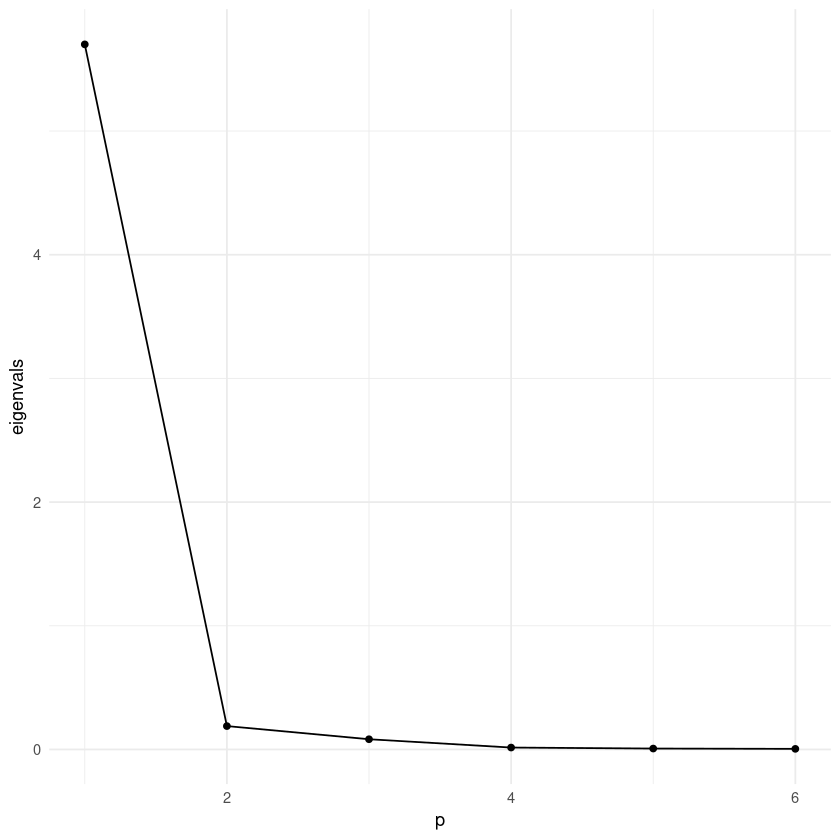

In [32]:
elbow_dat_cy <- data.frame(p = 1:6, eigenvals = specdecomp_cy$values)
elbow_cy <- ggplot(aes(x = p, y = eigenvals), data = elbow_dat_cy) +
geom_line() + 
geom_point () + 
theme_minimal()

ggsave("elbow_epca_cy_genmlm.pdf", elbow_cy)
elbow_cy